In [2]:
import sys
sys.path.append(f'/home/a/acw694/CLIPort_new_loss/mae')

import models_lib
import torch
import numpy as np
import matplotlib.pyplot as plt
from dataset_mae import MAEDataset
from torchvision import transforms
from PIL import Image
from torch.utils.data import DataLoader, Subset
import cv2

In [3]:
MEAN_CLIPORT = [0.48145466, 0.4578275, 0.40821073]
STD_CLIPORT = [0.26862954, 0.26130258, 0.27577711]
device = 'cuda'

def get_fix_transform():
    trasform_fix = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224,224)),
        transforms.Normalize(mean=MEAN_CLIPORT, std=STD_CLIPORT)])
    return trasform_fix

def generate_token(text_processor, lang, device):
    if type(lang) is str:
        decoded_strings = [lang]
    else:
        decoded_strings = [s.decode('ascii') for s in lang]
    processed_lang = text_processor(text=decoded_strings, padding="max_length", return_tensors='pt')
    processed_lang = processed_lang.to(device)
    return processed_lang

def load_image_to_tensor(image_path):
    """
    Load an image from the specified path and convert it to a PyTorch tensor.

    Args:
        image_path (str): The path to the image file.

    Returns:
        torch.Tensor: The image converted to a PyTorch tensor.
    """
    # Define the transform to convert the image to a tensor
    transform = transforms.Compose([
        transforms.Resize((320, 160)),
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN_CLIPORT, std=STD_CLIPORT)])

    # Load the image
    image = Image.open(image_path)

    # Apply the transform to the image
    image_tensor = transform(image)

    # Optional: Move the tensor to GPU if available
    if torch.cuda.is_available():
        image_tensor = image_tensor.to('cuda')
        print('Tensor moved to GPU')
    
    return image_tensor

def get_random_batch(idx):
    subset_indices = [idx]
    subset = Subset(dataset_vis, subset_indices)
    subset_loader = DataLoader(subset, batch_size=1, shuffle=False)
    batch = next(iter(subset_loader))
    return batch

def show_image_relevance(image_relevance, image):
    # create heatmap from mask on image
    def show_cam_on_image(img, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        return cam

    fig, axs = plt.subplots(1, 2)    
    image = (image - image.min()) / (image.max() - image.min())
    image = image[0].permute(1, 2, 0).cpu().numpy()    
    axs[0].imshow(image);
    axs[0].axis('off');
    
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    image_relevance = image_relevance[0].permute(1, 2, 0).data.cpu().numpy()

    vis = show_cam_on_image(image, image_relevance)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    axs[1].imshow(vis);
    axs[1].axis('off');

In [743]:
# load data and model
MODEL = 'mae_fuse'
CHECKPOINT = '/home/a/acw694/CLIPort_new_loss/exps/0607_mae_fuse_4dataset/checkpoint-220.pth'
#/home/a/acw694/CLIPort_new_loss/exps/0424_multisize_from_scratch_m95/checkpoint-399.pth
#/home/a/acw694/CLIPort_new_loss/exps/0411_fuse_multisize/fuse_multisize_checkpoint-399.pth
#/home/a/acw694/CLIPort_new_loss/exps/0607_mae_fuse_4dataset/checkpoint-220.pth
model = models_lib.__dict__[MODEL](img_size=(224,224), norm_pix_loss=False)
model.to(device)
checkpoint = torch.load(CHECKPOINT, map_location='cpu')
model.load_state_dict(checkpoint['model'], strict=False)

Loaded CLIP text model: openai/clip-vit-base-patch32


/tmp/ipykernel_3238761/4262269795.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(CHECKPOINT, map_location='cpu')


<All keys matched successfully>

In [80]:
from transformers import AutoTokenizer
text_processor = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

Tensor moved to GPU


### Load image from explorer and indicate your own langauge

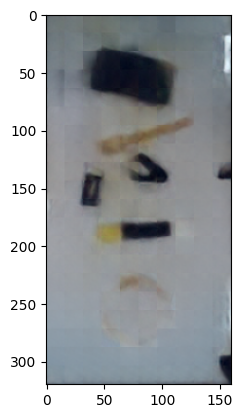

In [17]:
img_input = load_image_to_tensor('/jmain02/home/J2AD007/txk47/cxz00-txk47/cliport/test_new2.png')
img_input = img_input.unsqueeze(0)
img_input=img_input[:,:3,:,:]
input_lang =  "put the yellow ball on the black phone"

lang_processed =generate_token(text_processor, input_lang, device)
with torch.no_grad():
    
    loss, predict, mask = model(img_input, img_input, None, None, lang_processed, mask_ratio=1.00)
    predict = model.unpatchify(predict)
    predict = predict.detach().cpu()
    predict = predict[0]
    predict = (predict - predict.min()
            ) / (predict.max() - predict.min())
    predict = predict.permute(1, 2, 0).numpy()

plt.imshow(predict)

### Get image from your dataset and show the result

In [603]:
# load dataset
transform_train = get_fix_transform()
TEST_PATH = '/home/a/acw694/CLIPort_new_loss/scratch/bridge_256_val.hdf5'
dataset_vis = MAEDataset(transform=transform_train, data_path=TEST_PATH)
TESTSET_IDX = [0,716,1216,1716,2205,2694,2928,3205,3305,3535,3757,3924,4091,5015,5933,6570,7207,7920,8633]
dataloader = DataLoader(dataset_vis, batch_size=1, shuffle=False)
dataloader = iter(dataloader)
i=0

Length of the dataset:  4357


(b'unfold from top to bottom',)
0


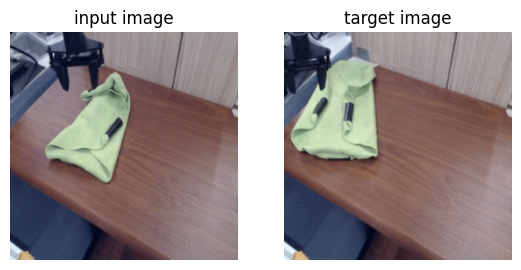

In [802]:
batch = get_random_batch(1)
#batch = next(dataloader)
i=0
img1, img2, lang, pick, place = batch
img1 = img1.to(device, non_blocking=True).float()
img2 = img2.to(device, non_blocking=True).float()
pick = pick.to(device, non_blocking=True).float()
place = place.to(device, non_blocking=True).float()

img1_show = (img1 - img1.min()) / (img1.max() - img1.min())
img2_show = (img2 - img2.min())/ (img2.max() - img2.min())
img1_show = img1_show[0].permute(1, 2, 0).cpu().numpy()
img2_show = img2_show[0].permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(img1_show)
plt.title('input image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img2_show)
plt.title('target image')
plt.axis('off')
print(lang)
print(i)

original lang is (b'move the duck toy on the top of the drawer',)
Please input your lang ...


 move the green pepper on the top of the drawer


(-0.5, 223.5, 223.5, -0.5)

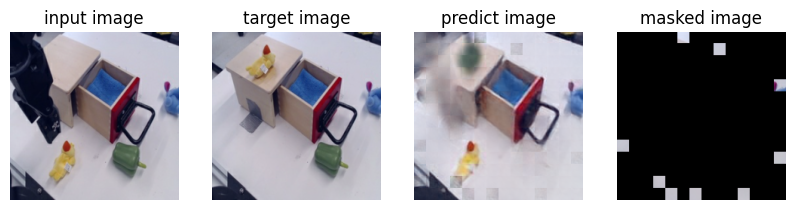

In [799]:
img1, img2, lang, pick, place = batch
img1 = img1.to(device, non_blocking=True).float()
img2 = img2.to(device, non_blocking=True).float()
pick = pick.to(device, non_blocking=True).float()
place = place.to(device, non_blocking=True).float()

img1_show = (img1 - img1.min()) / (img1.max() - img1.min())
img2_show = (img2 - img2.min())/ (img2.max() - img2.min())
img1_show = img1_show[0].permute(1, 2, 0).cpu().numpy()
img2_show = img2_show[0].permute(1, 2, 0).cpu().numpy()

# show input image
plt.figure(figsize=(10, 5))
plt.subplot(1, 4, 1)
plt.imshow(img1_show)
plt.title('input image')
plt.axis('off')

# show target image
plt.subplot(1, 4, 2)
plt.imshow(img2_show)
plt.title('target image')
plt.axis('off')

# get prompt text
print(f"original lang is {lang}")
print("Please input your lang ...")
input_lang = input()
lang_input = input_lang if input_lang else lang
lang_processed = generate_token(text_processor, lang_input, device)

# pass the model
loss, predict, mask = model(img1, img2, pick, place, lang_processed, mask_ratio=0.95)
predict = model.unpatchify(predict)
predict = predict.detach().cpu()
predict = predict[0]
predict = (predict - predict.min()) / (predict.max() - predict.min())
predict = predict.permute(1, 2, 0).numpy()

# show the prediction
plt.subplot(1, 4, 3)
plt.imshow(predict)
plt.title('predict image')
plt.axis('off')

# show the masked image
img2 = img2.detach().cpu()
img2 = img2[0]
img2 = (img2 - img2.min()) / (img2.max() - img2.min())

mask = mask.detach().cpu()
mask = mask.detach()
mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0] ** 2 * 3)  # (N, H*W, p*p*3)
mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
mask = mask[0]
mask = mask.permute(2, 0, 1)
im_masked = img2 * (1 - mask)
im_masked = im_masked.permute(1,2,0).numpy()

plt.subplot(1, 4, 4)
plt.imshow(im_masked)
plt.title('masked image')
plt.axis('off')



In [800]:
def save_image(img_array, filename):
    img = (img_array * 255).astype('uint8')
    img_pil = Image.fromarray(img)
    img_pil.save(filename)
    print(f"✅ Saved: {filename}")

# 让用户输入一个名字，例如 "green cloth"
base_name = input("请输入图像基础名字（例如 green cloth）:\n").strip()
if not base_name:
    base_name = "unnamed"

# 组装文件名
filenames = {
    'input_image': f"{base_name}_input.png",
    'target_image': f"{base_name}_target.png",
    'predict_image': f"{base_name}_predict.png",
    'masked_image': f"{base_name}_masked.png",
}

# 保存四张图
save_image(img1_show, filenames['input_image'])
save_image(img2_show, filenames['target_image'])
save_image(predict, filenames['predict_image'])
save_image(im_masked, filenames['masked_image'])

请输入图像基础名字（例如 green cloth）:
 green pepper


✅ Saved: green pepper_input.png
✅ Saved: green pepper_target.png
✅ Saved: green pepper_predict.png
✅ Saved: green pepper_masked.png


In [30]:
relevance = model.show_relevance_map(img1,lang_processed)
show_image_relevance(relevance, img1)

ModuleAttributeError: 'MAERobotLang' object has no attribute 'show_relevance_map'

In [21]:
from cliport.real_dataset import RealDataset
task = "pack_objects"
batch_size=1
val_ds = RealDataset(task_name=task,data_type='test_unseen', augment=False)
val_ds = DataLoader(val_ds, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=0)
val_ds = iter(val_ds)

Loading real new dataset...


In [22]:
img1 = batch[0]['img'][:,:,:,:3]
img1 = img1.permute(0,3,1,2)
img1

TypeError: new(): invalid data type 'str'

original lang is pack the soft ball in the brown box
Please input your lang ...


(-0.5, 159.5, 319.5, -0.5)

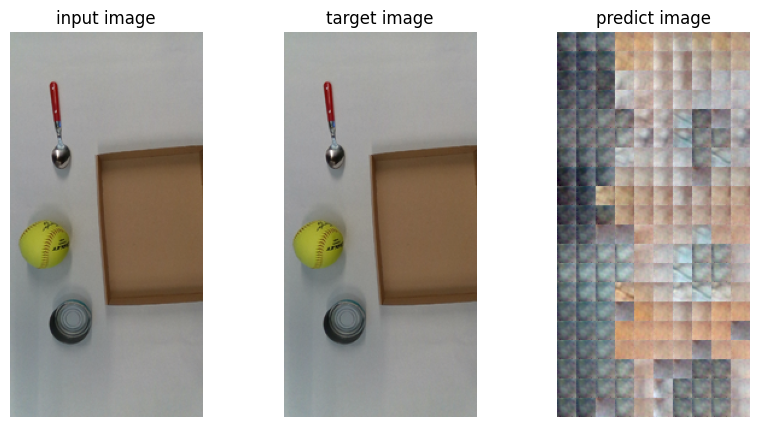

In [27]:
batch = next(val_ds)

lang_input = batch[0]['lang_goal'][0]
print(f"original lang is {lang_input}")
print("Please input your lang ...")
input_lang = input()
lang_input = input_lang if input_lang else lang
lang_processed = generate_token(text_processor, lang_input, device)
img1 = batch[0]['img'][:,:,:,:3]
img1 = img1.permute(0,3,1,2)
pick = 0
place = 0
img1 = img1.to('cuda').float()
img2 = img1
loss, predict, mask = model(img1, img2, pick, place, lang_processed, mask_ratio=0.95)
predict = model.unpatchify(predict)
predict = predict.detach().cpu()
predict = predict[0]
predict = (predict - predict.min()) / (predict.max() - predict.min())
predict = predict.permute(1, 2, 0).numpy()

img1_show = (img1 - img1.min()) / (img1.max() - img1.min())
img2_show = (img2 - img2.min())/ (img2.max() - img2.min())
img1_show = img1_show[0].permute(1, 2, 0).cpu().numpy()
img2_show = img2_show[0].permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(img1_show)
plt.title('input image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img2_show)
plt.title('target image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(predict)
plt.title('predict image')
plt.axis('off')

Tensor moved to GPU
the man wearing glasses


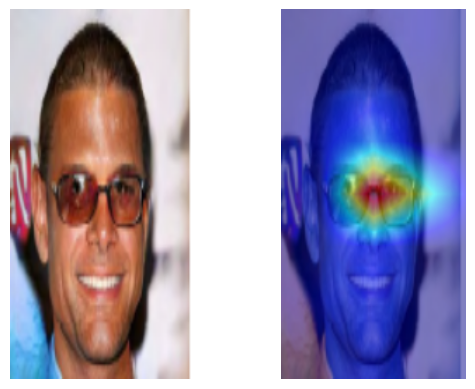

In [68]:
img_input = load_image_to_tensor('/jmain02/home/J2AD007/txk47/cxz00-txk47/cliport/glasses.png')
img_input = img_input.unsqueeze(0)
input_lang = input()
lang_processed =generate_token(text_processor, input_lang, device)
relevance = model.show_relevance_map(img_input,lang_processed)
show_image_relevance(relevance, img_input)

Tensor moved to GPU
test


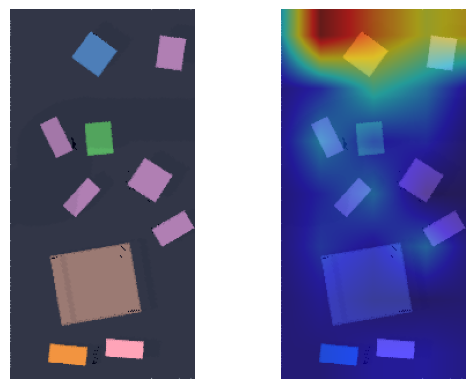

In [59]:
img_input = load_image_to_tensor('/jmain02/home/J2AD007/txk47/cxz00-txk47/DiffPort/data_gt_real_images/real0.png')
img_input = img_input.unsqueeze(0)


In [14]:
img_input.shape

torch.Size([1, 3, 320, 160])

the red plate


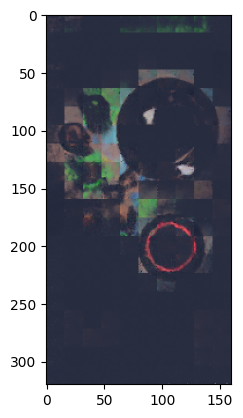

In [46]:
input_lang = input()
lang_processed = generate_token(text_processor, lang_input, device)

with torch.no_grad():
    
    loss, predict, mask = model(img_input, img_input, pick, place, lang_processed, mask_ratio=0.95)
    predict = model.unpatchify(predict)
    predict = predict.detach().cpu()
    predict = predict[0]
    predict = (predict - predict.min()
            ) / (predict.max() - predict.min())
    predict = predict.permute(1, 2, 0).numpy()

plt.imshow(predict)